In [1]:
import sapien.core as sapien
from Tools import misc, ForwardKinematics, ModelSim, NumForwardDynamicsDer
import numpy as onp
import jax.numpy as np
from jax import jit, jacfwd, jacrev, grad
from ilqr import ILQR
from datetime import datetime
from tqdm.notebook import trange
import matplotlib.pyplot as plt

%matplotlib notebook
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.40

Using default glsl path /home/zack/anaconda3/envs/ml/lib/python3.7/site-packages/sapien/glsl_shader/130
env: XLA_PYTHON_CLIENT_MEM_FRACTION=.40


In [2]:
DEBUG = False

sim = sapien.Engine()
renderer = sapien.OptifuserRenderer()
sim.set_renderer(renderer)
render_controller = sapien.OptifuserController(renderer)

stabled = False


def create_scene(timestep, visual):
    s = sim.create_scene([0, 0, 0])
    s.add_ground(-1)
    s.set_timestep(timestep)

    loader = s.create_urdf_loader()
    loader.fix_root_link = True
    if visual:
        loader.collision_is_visual = True
        s.set_ambient_light([0.5, 0.5, 0.5])
        s.set_shadow_light([0, 1, -1], [0.5, 0.5, 0.5])

    # build
    robot = loader.load("../../../assets/Arm/panda.urdf")
    
    for _ in range(3000):
        s.step()

    return s, robot


sim_timestep = 1 / 60
optim_timestep = 1 / 60
s0, robot = create_scene(sim_timestep, True)

render_controller.set_camera_position(-5, 0, 0)
render_controller.set_current_scene(s0)


In [3]:
num_deri = NumForwardDynamicsDer(robot, sim_timestep)
fk = ForwardKinematics(robot)
sim_worker = ModelSim(create_scene, optim_timestep)

In [4]:
# render_controller.show_window()
# while True:
#     u = onp.random.randn(robot.dof) * 0.5
#     u = onp.clip(u, -1, 1)
#     robot.set_qf(u)
#     s0.step()
#     s0.update_render()
#     render_controller.render()


def smooth_abs(x, alpha):
    return np.mean((alpha ** 2) * (np.cosh(x / alpha) - 1))


robo_pose = robot.get_root_pose()

u_range = robot.get_qlimits().T
pred_time = 5
horizon = int(pred_time / optim_timestep) + 1
per_iter = 2

@jit
def final_cost(x, alpha=0.3):
    # add base pose
    x = np.concatenate((x, robo_pose.p, robo_pose.q))

    cart_pos = fk.fk(x).reshape(-1, 3)[:, :3]
    end_effector_pos = cart_pos[-3]

    target_pos = robo_pose.p + [0, 0, 1.2]
    term1 = smooth_abs(end_effector_pos[2] - target_pos[2], alpha)

    return term1

@jit
def running_cost(x, u, alpha=0.5):
    eps = 1e-9
    u_normalized = np.where(u>=0, u/(u_range[1]+eps), u/(u_range[0] + eps))
    term1 = smooth_abs(u_normalized, alpha) / horizon
    return term1

In [5]:
ilqr = ILQR(final_cost, running_cost, None, u_range, horizon, per_iter, num_deri, sim_worker, DEBUG)

In [6]:
state = misc.get_state(robot)
num_x = len(state)
num_u = robot.dof
dof = robot.dof

# prep seq
x_seq = []
u_seq = []
pack_seq = []

bak_pack = robot.pack()

for i in range(horizon):
    u = onp.random.randn(robot.dof) * 0.5
    u = onp.clip(u, u_range[0], u_range[1])

    x = misc.get_state(robot)
    pack = robot.pack()

    x_seq.append(x)
    pack_seq.append(pack)
    u_seq.append(u)

    robot.set_qf(u)
    s0.step()
robot.unpack(bak_pack)

<IPython.core.display.Javascript object>


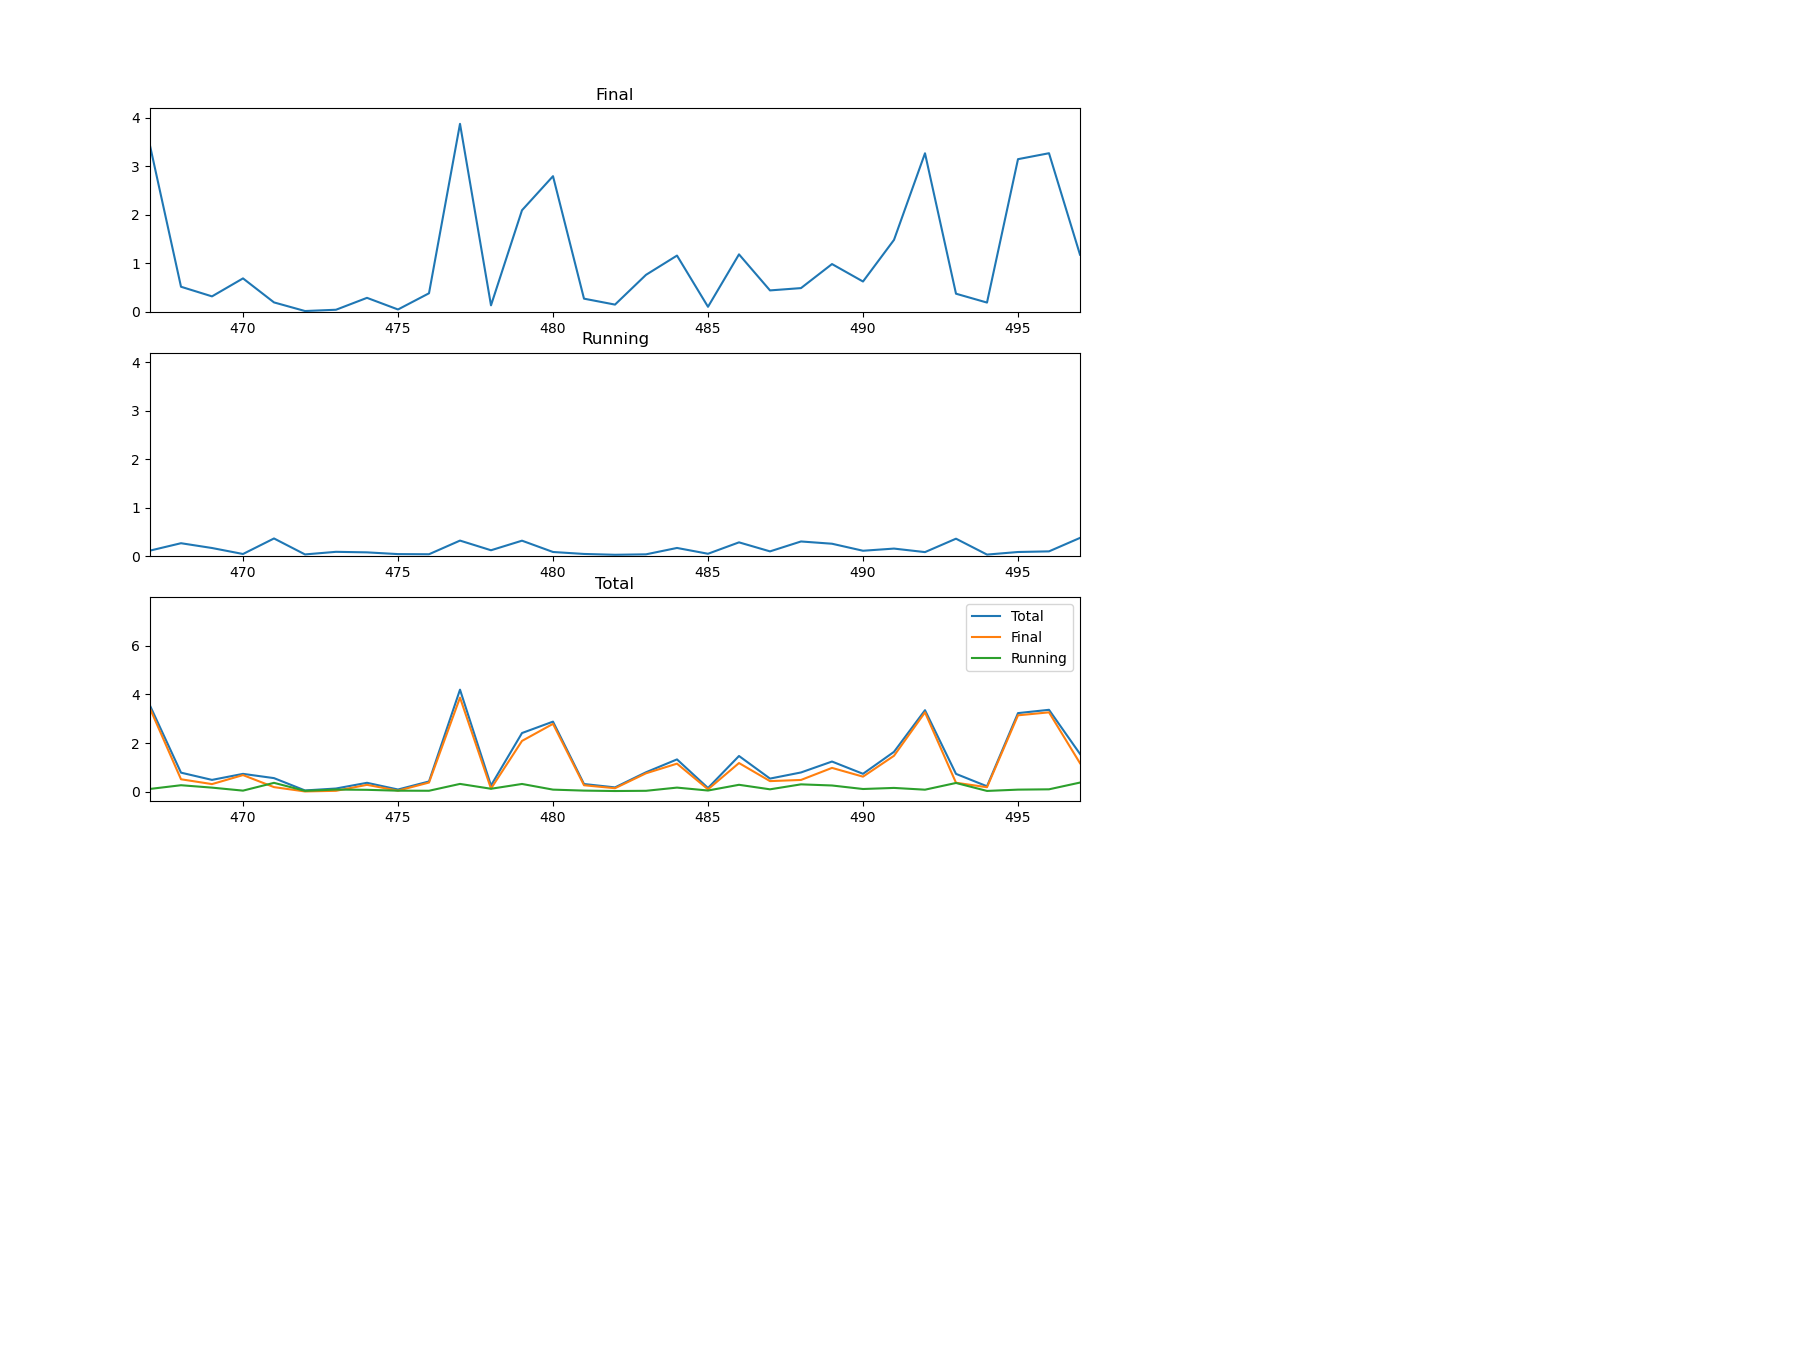

/home/zack/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/home/zack/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/home/zack/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


In [ ]:
# records
ctrl_record = []
x_record = []
u_record = []
run_cost_record = []
f_cost_record = []
ini_state = [bak_pack]

# plots
IF_PLOT = True

if IF_PLOT:
    fig, axs = plt.subplots(3,figsize=(12,9))

    total = []
    f_ax, r_ax, t_ax = axs
    PLOT_LEN = 30

    plt.ion()

    fig.show()
    fig.canvas.draw()

render_controller.show_window()
for i in trange(500):
    x_seq, u_seq, pack_seq = ilqr.predict(x_seq, u_seq, pack_seq)

    u = u_seq[0]

    robot.set_qf(u)
    s0.step()
    s0.update_render()
    render_controller.render()

    new_x = misc.get_state(robot)
    new_pack = robot.pack()

    f_cost = final_cost(x_seq[-1])
    run_cost = onp.sum([running_cost(x, u) for x, u in zip(x_seq[:-1], u_seq[:-1])])
    cost = f_cost + run_cost

    # record
    ctrl_record.append(u)
    f_cost_record.append(f_cost)
    run_cost_record.append(run_cost)
    x_record.append(x_seq)
    u_record.append(u_seq)

    # update x and u, since we need to record old x u
    x_seq[0] = new_x
    pack_seq[0] = new_pack

    # plot
    if IF_PLOT:
        total.append(cost)
        f_ax.clear()
        r_ax.clear()
        t_ax.clear()

        y_lim = np.max(total[-PLOT_LEN:])
        f_ax.set_ylim(0, y_lim)
        r_ax.set_ylim(0, y_lim)
        f_ax.set_ylim(0, y_lim)

        x_lim = max(0, i - PLOT_LEN)
        f_ax.set_xlim(x_lim, i)
        r_ax.set_xlim(x_lim, i)
        t_ax.set_xlim(x_lim, i)


        f_ax.plot(f_cost_record)
        f_ax.set_title("Final")
        r_ax.plot(run_cost_record)
        r_ax.set_title("Running")

        t_ax.plot(total, label="Total")
        t_ax.plot(f_cost_record, label="Final")
        t_ax.plot(run_cost_record, label="Running")
        t_ax.legend()
        t_ax.set_title("Total")

        fig.canvas.draw()
        fig.show()


In [ ]:
records = {
    'ctrl_record': ctrl_record,
    'x_record': x_record,
    'u_record': u_record,
    'run_cost_record': run_cost_record,
    'f_cost_record': f_cost_record,
    'ini_state': ini_state,
}

np.save('records' + str(datetime.utcnow()), records)
